In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from string import punctuation
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words

from collections import Counter

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data.csv')
df.sample(3)

,text,label
1378,Правительство утвердило повышение экспортной п...,меры поддержки
1449,Путин заявил о попытках извне помешать граждан...,не по теме
149,Байден отшутился в ответ на вопросы журналисто...,политика


In [4]:
stopwordslist = set(get_stop_words("russian")) #+ ['это', 'которые']
lemmatizer = WordNetLemmatizer()
ptrn_url = r'\w+:\/+[a-zA-Z0-9\.\/\_\:\-]+'
ptrn_meta = r'(\/.\w+){1,3}'
ptrn_meta2 = r"\[@[\w]+\=(.){1,2}\w+\:\w+\\']"
ptrn_data = r'(\d+\.){2}\d{4}|(\d+\-\d+){2}\d+\w\d+:\d+'
ptrn_phone = r'\d[\ \d{3}]+\-\d+'
# ptrn = r'[^a-zA-Zа-яА-Я0-9\%]'
ptrn = r'[^а-яА-Я0-9\%]'

def remove_url(text):
    text = re.sub(ptrn_url, '', text)
    text = re.sub(ptrn_meta, '', text)
    text = re.sub(ptrn_meta2, '', text)
    text = re.sub(ptrn_data, '', text)
    text = re.sub(ptrn_phone, '', text)
    return text

def words_only(text):
    text=str(text)
    return text.lower()

def remove_punkt(text):
    return re.sub(ptrn, ' ', text)

def to_token(text):
    return word_tokenize(text)

def remove_stopwords(text):
    text_list = [w for w in text if w not in stopwordslist]
    return ' '.join(word for word in text_list)

def morphe_text(text):
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwordslist]
    return " ".join(text)

def normalize_text(text):
    text = remove_url(text)
    text = words_only(text)
    text = remove_punkt(text)
    text = to_token(text)
    text = remove_stopwords(text)
    text = morphe_text(text)
    return text

In [5]:
df['Content_norm'] = df['text'].apply(normalize_text)

In [6]:
dubl = df.duplicated(['Content_norm'])
df[dubl == True]

,text,label,Content_norm
1343,"Посол Индии в России рассказал, как себя чувст...",COVID-19,посол индии россии рассказал чувствует прививк...
1781,"Слуцкий заявил, что добиться выхода России из ...",мнения,слуцкий заявил добиться выхода россии пасе пол...
1802,"Соратник Навального рассказал, как его вывезли...",не по теме,соратник навального рассказал вывезли границу ...
2155,"🧙‍♀ Гороскоп на сегодня, 26 января, для всех з...",не по теме,гороскоп 26 января знаков зодиака ежедневный г...


In [7]:
df = df[dubl == False]
df.sample(3)

,text,label,Content_norm
1959,Умер бывший вице-премьер Сергей Приходько\nУме...,не по теме,умер бывший вице премьер сергей приходько умер...
462,В сети обсудили указ о повышении пошлин на экс...,мнения,сети обсудили указ повышении пошлин экспорт пш...
1366,Пошлины на пшеницу в РФ понизят лишь в конце л...,торговля,пошлины пшеницу рф понизят конце лета 2021 про...


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_norm'], df['label'], test_size=0.33, random_state=42, stratify=df['label'])


In [9]:
corpus = [token for new in df["Content_norm"] for token in word_tokenize(new)]
print(len(corpus))
corpus[:10]

1272575


['34',
 'регионе',
 'стало',
 'пахнуть',
 'россией',
 '34',
 'главные',
 'претензии',
 'пашиняну',
 'армении']

In [10]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('января', 9207),
 ('россии', 8809),
 ('2021', 6188),
 ('сша', 5127),
 ('текст', 4910),
 ('заявил', 4396),
 ('ранее', 4163),
 ('новости', 3444),
 ('%', 3185),
 ('коронавируса', 3023)]

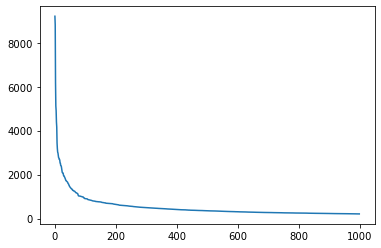

In [11]:
first_100_freqs = [freq for word, freq in freq_dict_sorted[:1000]]
plt.plot(first_100_freqs)
plt.show()

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train) 
y_test = le.transform(y_test)
le.classes_

array(['COVID-19', 'Международные отношения', 'Россия',
       'Социологические опросы', 'аналитика', 'военная тематика',
       'инвестиция', 'меры поддержки', 'мнения', 'не по теме', 'политика',
       'проекты', 'торговля'], dtype=object)

#### Смотрим токены с высокой частотой

In [13]:
tokens_high = [token[0] for token in freq_dict_sorted[:200]]

vec = TfidfVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      vocabulary=tokens_high)
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred_high = clf.predict(vec.transform(X_test))
pred_high_proba = clf.predict_proba(vec.transform(X_test))
print(classification_report(pred_high, y_test, target_names=le.classes_))

                         precision    recall  f1-score   support

               COVID-19       0.70      0.63      0.66        90
Международные отношения       0.20      0.60      0.30        20
                 Россия       0.00      0.00      0.00         0
 Социологические опросы       0.00      0.00      0.00         0
              аналитика       0.36      0.63      0.46        19
       военная тематика       0.16      0.75      0.27         8
             инвестиция       0.00      0.00      0.00         0
         меры поддержки       0.00      0.00      0.00         0
                 мнения       0.09      0.33      0.15        12
             не по теме       0.93      0.61      0.73       449
               политика       0.58      0.64      0.61       108
                проекты       0.00      0.00      0.00         0
               торговля       0.12      0.60      0.21         5

               accuracy                           0.61       711
              macro avg

#### Смотрим токены со средней частотой

In [14]:
tokens_middle = [token[0] for token in freq_dict_sorted[200:800]]
vec = CountVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      vocabulary=tokens_middle)
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred_mid = clf.predict(vec.transform(X_test))
print(classification_report(pred_mid, y_test, target_names=le.classes_))

                         precision    recall  f1-score   support

               COVID-19       0.68      0.70      0.69        80
Международные отношения       0.22      0.30      0.25        43
                 Россия       0.00      0.00      0.00         1
 Социологические опросы       0.00      0.00      0.00         0
              аналитика       0.27      0.39      0.32        23
       военная тематика       0.43      0.50      0.46        32
             инвестиция       0.33      0.50      0.40         2
         меры поддержки       0.10      0.14      0.12         7
                 мнения       0.33      0.30      0.31        47
             не по теме       0.78      0.66      0.71       347
               политика       0.49      0.52      0.51       111
                проекты       0.00      0.00      0.00         0
               торговля       0.25      0.33      0.29        18

               accuracy                           0.57       711
              macro avg

#### Смотрим токены с низкой частотой

In [15]:
tokens_low = [token[0] for token in freq_dict_sorted[800:]]
vec = CountVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      vocabulary=tokens_low)
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred_low = clf.predict(vec.transform(X_test))
pred_low_proba = clf.predict_proba(vec.transform(X_test))
print(classification_report(pred_low, y_test, target_names=le.classes_))

                         precision    recall  f1-score   support

               COVID-19       0.71      0.76      0.73        76
Международные отношения       0.32      0.49      0.39        39
                 Россия       0.00      0.00      0.00         0
 Социологические опросы       0.00      0.00      0.00         0
              аналитика       0.39      0.43      0.41        30
       военная тематика       0.35      0.72      0.47        18
             инвестиция       0.33      0.33      0.33         3
         меры поддержки       0.10      0.25      0.14         4
                 мнения       0.33      0.50      0.39        28
             не по теме       0.91      0.68      0.78       390
               политика       0.57      0.65      0.61       103
                проекты       0.25      1.00      0.40         1
               торговля       0.29      0.37      0.33        19

               accuracy                           0.65       711
              macro avg

#### Обучение на всем корпусе

In [16]:
tokens_all = [token[0] for token in freq_dict_sorted]

vec = TfidfVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      vocabulary=tokens_all)
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred_all = clf.predict(vec.transform(X_test))
print(classification_report(pred_all, y_test, target_names=le.classes_))

                         precision    recall  f1-score   support

               COVID-19       0.61      0.76      0.68        66
Международные отношения       0.19      0.73      0.30        15
                 Россия       0.00      0.00      0.00         0
 Социологические опросы       0.00      0.00      0.00         0
              аналитика       0.24      0.73      0.36        11
       военная тематика       0.11      1.00      0.20         4
             инвестиция       0.00      0.00      0.00         0
         меры поддержки       0.00      0.00      0.00         0
                 мнения       0.05      0.33      0.08         6
             не по теме       0.97      0.55      0.70       522
               политика       0.47      0.69      0.56        80
                проекты       0.00      0.00      0.00         0
               торговля       0.17      0.57      0.26         7

               accuracy                           0.59       711
              macro avg

In [17]:
tokens_high = [token[0] for token in freq_dict_sorted[:200]]

vec = TfidfVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      vocabulary=tokens_high)
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred_high = clf.predict(vec.transform(X_test))


In [18]:
preds_proba = pred_high_proba * 0.3 + pred_low_proba * 0.7

In [19]:
print(classification_report(preds_proba.argmax(axis=1), y_test, target_names=le.classes_))

                         precision    recall  f1-score   support

               COVID-19       0.78      0.79      0.79        81
Международные отношения       0.31      0.50      0.38        36
                 Россия       0.00      0.00      0.00         0
 Социологические опросы       0.00      0.00      0.00         0
              аналитика       0.42      0.50      0.46        28
       военная тематика       0.38      0.74      0.50        19
             инвестиция       0.33      0.33      0.33         3
         меры поддержки       0.10      0.33      0.15         3
                 мнения       0.33      0.54      0.41        26
             не по теме       0.92      0.68      0.78       397
               политика       0.58      0.67      0.62       101
                проекты       0.25      1.00      0.40         1
               торговля       0.25      0.38      0.30        16

               accuracy                           0.66       711
              macro avg

### Хэшинг векторизатор

In [20]:
vec = HashingVectorizer(n_features=10000, 
                        tokenizer=word_tokenize)
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71        73
           1       0.22      0.65      0.33        20
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.30      0.67      0.42        15
           5       0.14      1.00      0.24         5
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.07      0.38      0.12         8
           9       0.97      0.59      0.73       486
          10       0.56      0.69      0.62        96
          11       0.00      0.00      0.00         0
          12       0.17      0.50      0.25         8

    accuracy                           0.62       711
   macro avg       0.24      0.40      0.26       711
weighted avg       0.82      0.62      0.68       711



### GradientBoostingClassifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
tokens_high = [token[0] for token in freq_dict_sorted[:200]]

vec = TfidfVectorizer(ngram_range=(1, 1), 
                      tokenizer=word_tokenize,
                      vocabulary=tokens_high)
bow = vec.fit_transform(X_train)
clf = GradientBoostingClassifier(n_estimators=1000, random_state=42)
clf.fit(bow, y_train)
pred_high = clf.predict(vec.transform(X_test))
pred_high_proba = clf.predict_proba(vec.transform(X_test))
print(classification_report(pred_high, y_test, target_names=le.classes_))

                         precision    recall  f1-score   support

               COVID-19       0.73      0.69      0.71        87
Международные отношения       0.24      0.44      0.31        32
                 Россия       0.00      0.00      0.00         0
 Социологические опросы       0.00      0.00      0.00         0
              аналитика       0.24      0.38      0.30        21
       военная тематика       0.11      0.27      0.15        15
             инвестиция       0.00      0.00      0.00         1
         меры поддержки       0.10      0.20      0.13         5
                 мнения       0.14      0.30      0.19        20
             не по теме       0.85      0.63      0.72       397
               политика       0.57      0.56      0.57       119
                проекты       0.00      0.00      0.00         0
               торговля       0.21      0.36      0.26        14

               accuracy                           0.58       711
              macro avg